# Week 5: Outlier detection

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

# Local imports
import sys
sys.path.append('..')
#from utilities.load_data import load_iris_PC, load_iris, load_synthetic_data

ModuleNotFoundError: No module named 'utilities'

## Exercise 1: Theory Questions
1. Please provide a brief definition of the task of outlier detection: what is the goal, and what are the challenges. 
2. Please provide a definition of an outlier according to the following approaches and discuss their similarities and differences:
    1. Statistical approaches 
    1. Distance-based (DB) 
    1. Local outlier factor (LOF) 
    1. Angle-based (ABOD) 
    1. Isolation-forest (IF) 
3. Create small examples, either visually or as a brief textual description, of an outlier that is NOT (well) captured by
    1. DB-Outlier 
    1. LOF 
    1. ABOD 

<hr/>

1. (find deviating data items; need to define deviation; challenge in few outliers vs many inliers; additional issues high-dimensionality, outlierness only in some attributes,…) 
2. Answers to two:
    1. (fit data to some model, look at extreme values / values that do not fit – e.g. one-d normal; issue high-d sparsity renders models infeasible; typically only 1-2d, at most 3-d)
    2. (define radius and percentage of points that are at most allowed within radius for point to be outlier – global model)
    3. (define number of neighbors k, look at ratio of distances to neighbors vs their distances to their neighbors; i.e., *local* difference in density indicates outliers)
    4. (use angles between pairs of points, which are supposed to be more stable in high-d than distances; low variance indicates outliers as they are far from everything else; not necessarily true, e.g. point in sparse center)
    5. (use ensemble of random decision trees (attributes, split values random) – outliers are typically separated early, i.e. have low path length on average)
3. Answers to three
    1. (varying densities; see motivating example for LOF in lecture)
    <img src="graphics/db_outlier.png" width="300"/>
    2. (outlier surrounded by several different clusters; high-d data)
    <img src="graphics/lof_outlier.png" width="300"/>
    3. (circle with sparse outlier at the center)
    <img src="graphics/angle_based_outlier.png" width="300"/>

## Exercise 2: Practical Example
Please consider the example data set below. Assuming Manhattan distance, please consider the following outlier detection setups.

<img src="graphics/W5.02.png" width="300"/>

In [2]:
def grid_data():
    return np.array([
        [1, 5], [2, 7], [3, 6], [3,7], [3,8], [4,5], [4,6], [4,7], [8,1], [8,4], [9,3], [9, 5]
    ])
X = grid_data()

1. For which parameters are the two highlighted objects outliers according to the distance based definition (DB)?
1. According to cluster-based outlier detection using DBSCAN with $MinPts = 4$ (including the object itself) and $\epsilon = 3$ which objects are outliers?
1. In statistical approaches, a way to identify outliers in a given attribute is to single out all objects that deviate by more than three times the standard deviation from the mean in this attribute. Look at 1d and 2d plots to identify outliers.
1. Determine the LOF for the two highlighted objects $p_1=(1,5)$, $p_2=(8,1)$ for $k=3$, $MinPts=3$.

In [3]:
# Code directly copied from https://matplotlib.org/3.1.3/gallery/statistics/confidence_ellipse.html#sphx-glr-gallery-statistics-confidence-ellipse-py
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`

    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

1. A point p is considered an outlier if at most $\pi$ percent of all other points have a distance to $\pi$ less than $e$. <br>
So one setting could be $\pi = 4 / 12$ and $\epsilon = 3$ or $\pi = 1/12$ and $\epsilon < 3$

2. None of the poitns are outliers. Had $\epsilon < 3$, then the small cluster and $[1, 5]$ would all have been outliers.

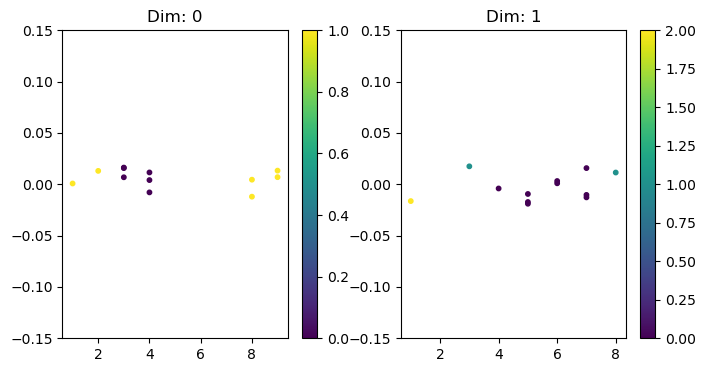

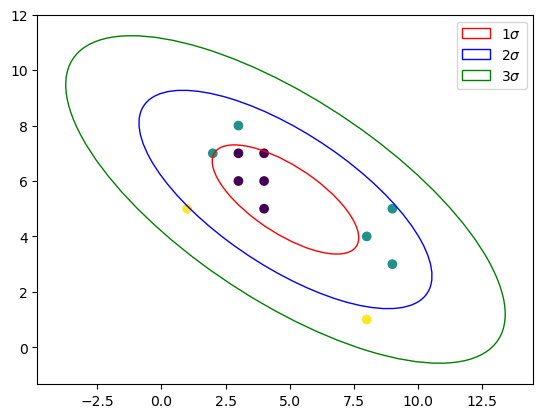

In [4]:
# 3. 1D and 2D plots of standard 3 standard deviations from the mean.
# 1D:
X = grid_data()
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

means = X.mean(0)
stds = X.std(0)

for dim in range(2):
    X_ = X[:,dim]
    mu = means[dim]
    std = stds[dim]
    y = np.zeros((X_.shape[0],))
    y[np.abs(X_-mu) > 1*std] = 1
    y[np.abs(X_-mu) > 2*std] = 2
    y[np.abs(X_-mu) > 3*std] = 3
    ax[dim].set_ylim([-0.15, 0.15])
    cf = ax[dim].scatter(X_, np.random.randn(X_.shape[0]) * 0.01, c=y, s=10) # Add a bit of noise to second dim to be able so tee points.
    ax[dim].set_title("Dim: %i" % dim)
    fig.colorbar(cf, ax=ax[[dim]])
    

# 2D sample
fig, ax = plt.subplots(1,1)

def std_dists(X):
    # Standardize X to have zero mean
    X_ = X - X.mean(axis=0, keepdims=True)
    
    # Transform into orthogonal space of covariance matrix
    S, U = np.linalg.eig(X_.T @ X_)
    X_hat = X_ @ (S * U)
    
    # Scale dimensions by standard deviations
    std = X_hat.std(axis=0)
    X_norm = X_hat / std
    dists = np.linalg.norm(X_norm, axis=1, ord=2)
    return dists


dists = std_dists(X)
y = np.zeros_like(dists, dtype=int)
y[dists > 1] = 1
y[dists > 2] = 2
y[dists > 3] = 3
ax.scatter(*(X.T), c=y)

confidence_ellipse(*(X.T), ax, n_std=1, edgecolor='red', label='$1\sigma$')
confidence_ellipse(*(X.T), ax, n_std=2, edgecolor='blue', label='$2\sigma$')
confidence_ellipse(*(X.T), ax, n_std=3, edgecolor='green', label='$3\sigma$')

plt.legend()

1.7896825396825398
1.3777777777777775
1.3333333333333333


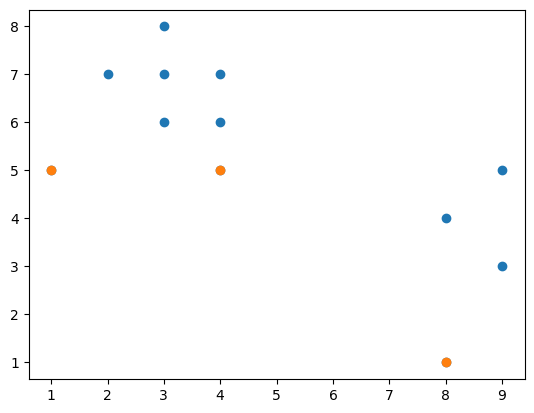

In [5]:
# 4. LOF for highlighted objects
X = grid_data()

p1 = [1., 5.]
p2 = [8., 1.]

k  = 3

neighborhoods  = []
kdists         = []

# Find neighbors and kdists
for i, x in enumerate(X):
    n = np.arange(X.shape[0])
    d = np.zeros_like(n, dtype=float)
    for j, x_ in enumerate(X):
        if i == j: continue # skip i it self
        d[j] = np.linalg.norm((x-x_), ord=1)
    args = np.argsort(d)
    ns = n[args]
    ds = d[args]

    kdist =  ds[k-1]
    #print(f'd:{d}\nns:{ns}\nds: {ds}\nkdist:{kdist}')
    kdists.append(kdist)
    neighborhoods.append(ns[ds <= kdist])

# Compute lrds
reach_dist = lambda i, j: max(kdists[j], np.linalg.norm(X[i]-X[j], ord=1))
lrds = []
for i, x in enumerate(X):
    lrd = 0
    for j in neighborhoods[i]:
        lrd += reach_dist(i, j)
    lrd /= len(neighborhoods[i])-1
    lrd = 1 / lrd
    lrds.append(lrd)

def LOF(i):
    lof = np.sum([lrds[j] for j in neighborhoods[i]])/len(neighborhoods[i])
    return lof / lrds[i]

lofs = [LOF(i)> 1.30 for i in range(len(X))]

plt.scatter(X[:,0],X[:,1])
plt.scatter(X[lofs,0],X[lofs,1])

for i in range(len(lofs)):
    if lofs[i]: print(LOF(i))

$$
\operatorname{lrd}_{k}(A):=1 /\left(\frac{\sum_{B \in N_{k}(A)} \text { reachability-distance }_{k}(A, B)}{\left|N_{k}(A)\right|}\right)
$$


$$
\operatorname{LOF}_{k}(A):=\frac{\sum_{B \in N_{k}(A)} \frac{\operatorname{lrd}_{k}(B)}{\operatorname{lrd}_{k}(A)}}{\left|N_{k}(A)\right|}=\frac{\sum_{B \in N_{k}(A)} \operatorname{lrd}_{k}(B)}{\left|N_{k}(A)\right|} / \operatorname{lrd}_{k}(A)
$$

## Exercise 3: Comparing Isolation Forest and LOF with statistical methods
For this exercise, we will be using sklearn to do outlier detection. 
We will use [LOF](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html) 
and [IF](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest).

We will use the following data.

/Users/au711141/Library/CloudStorage/OneDrive-Aarhusuniversitet/Denmark/Denmark/Phd/TA/DM/utilities/data/iris-PC.txt
/Users/au711141/Library/CloudStorage/OneDrive-Aarhusuniversitet/Denmark/Denmark/Phd/TA/DM/utilities/data/synth_multidim_010_000.arff


Text(0.5, 1.0, 'Hics subspace [8,9]')

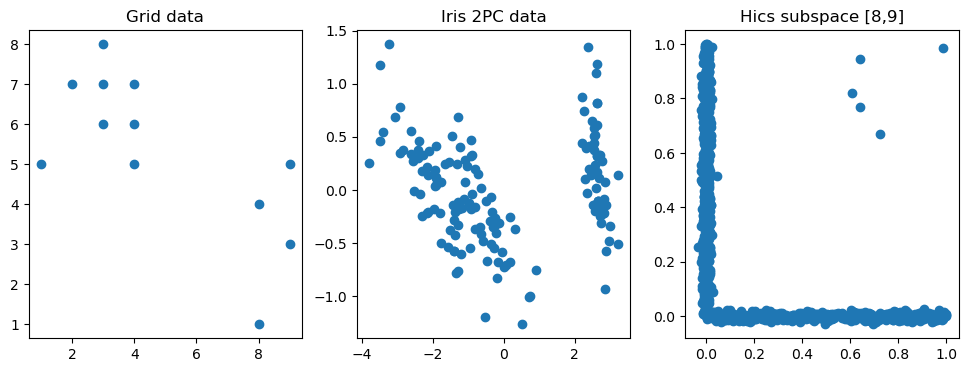

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
X_grid = grid_data()
X_iris, *_ = load_iris_PC()
X_hics, *_ = load_synthetic_data()
ax[0].scatter(*(X_grid.T))
ax[0].set_title('Grid data')
ax[1].scatter(*(X_iris.T))
ax[1].set_title('Iris 2PC data')
ax[2].scatter(*(X_hics[:,8:10].T))
ax[2].set_title('Hics subspace [8,9]')

In addition to LOF and IF, we will implement a simple version of `statistical_outliers` and `MDist`. 
For the former, we choose outliers as points where any of their features have a distance to the mean which exceeds $k$ standard deviations. 
For the latter, we normalize the data to have standard deviation 1 and then compute the $MDist(x, \mu) = (x-\mu)^T \Sigma^{-1} (x-\mu)$ where $\Sigma$ is an estimate of the covariance matrix.
`MDist` is going to take a threshold $k$, which decides the threshold for when a point is an outlier.

Fill in the following two method stubs.

In [7]:
def statistical_outliers(X, stds=3):
    X_ = X - X.mean(axis=0, keepdims=True)
    stds_ = X_.std(axis=0, keepdims=True)
    sel1 = X_ < -stds*stds_
    sel2 = X_ > stds*stds_
    # return np.all(sel1 | sel2, axis=1) * -1
    return np.any(sel1 | sel2, axis=1) * -1

def MDist(X, mdist=3):
    X_ =  X - X.mean(axis=0, keepdims=True)
    X_ = X_ / X.std(axis=0, keepdims=True)
    cov = np.cov(X_.T)
    dist = np.diag((X_)@cov) @ X_.T
    return (np.abs(dist) > mdist) * -1
 

Below is some code that runs the four algorithms on the different datasets.
_Before_ running the code, think about which points can be choosen as outliers for the different methods and which points cannot.

Does the resulting plots correspond to your expectations? If not, try to justify why?

/Users/au711141/Library/CloudStorage/OneDrive-Aarhusuniversitet/Denmark/Denmark/Phd/TA/DM/utilities/data/iris-PC.txt
/Users/au711141/Library/CloudStorage/OneDrive-Aarhusuniversitet/Denmark/Denmark/Phd/TA/DM/utilities/data/synth_multidim_010_000.arff


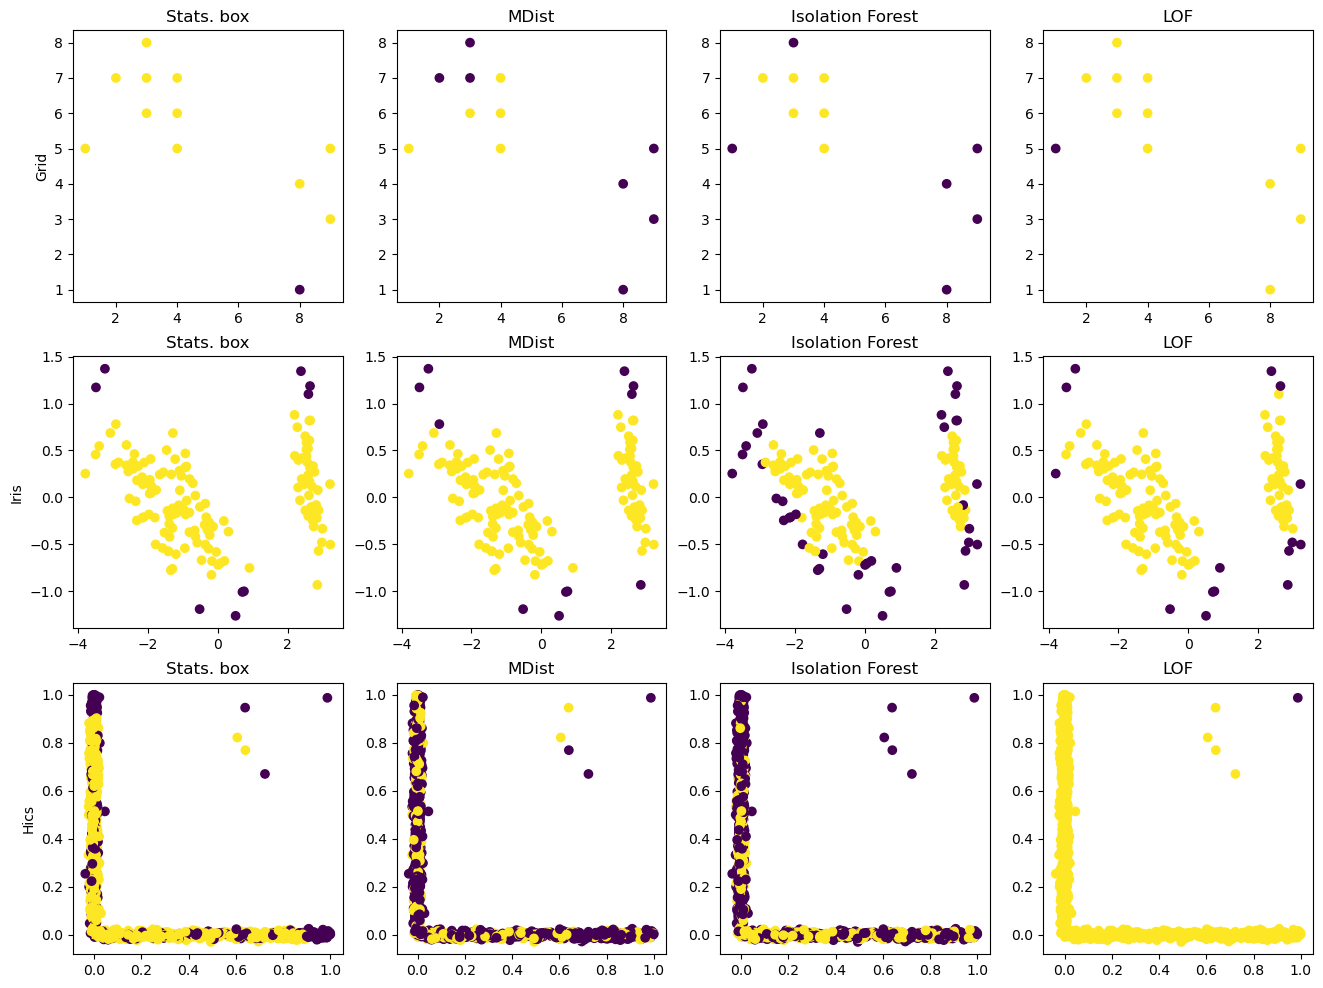

In [8]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
k =  2
fig, ax = plt.subplots(3,4, figsize=(16, 12))

for i, data in enumerate(['Grid', 'Iris', 'Hics']):
    n_neighbors  = 10
    if data == 'Grid':
        X           = grid_data()
        n_neighbors = 2
    elif data == 'Iris':
        X, _        = load_iris_PC()
    elif data == 'Hics':
        X, _        = load_synthetic_data()

    # Find outliers
    y1 = statistical_outliers(X, k)
    y2 = MDist(X, k)
    y3 = IsolationForest(n_estimators=10).fit_predict(X)
    y4 = LocalOutlierFactor(n_neighbors=n_neighbors).fit_predict(X)

    if data == 'Hics': # Project 10D data onto 2 dimensions.
        #Hicks data set has outliers in subspace dimensions [0,1], [6,7], [8, 9], and [2,3,4,5]
        # You could try plotting other subspaces
        X = X[:, 8:10]

    # Plot data
    ax[i, 0].set_title("Stats. box")
    cf = ax[i, 0].scatter(*(X.T), c=y1)
    ax[i, 1].set_title("MDist")
    ax[i, 1].scatter(*(X.T), cmap=cf.get_cmap(), c=y2)
    ax[i, 2].set_title("Isolation Forest")
    ax[i, 2].scatter(*(X.T), c=y3)
    ax[i, 3].set_title("LOF")
    ax[i, 3].scatter(*(X.T), c=y4)
    
    ax[i, 0].set_ylabel(data)

## Exercise 4: ABOD
In this exercise, we will implement the exact ABOD scores as well as a simple sampling strategy for approximating the ABOD score.
Recall, that the ABOD score is defined as

$$
ABOD(p) = \text{var}_{x,y\in DB} \left[ \frac{\langle px, py \rangle}{||px||^2||py||^2} \right]
$$

where $px$ and $py$ are vectors from $p$ to $x$ and $y$, respectively.

Below is a template for computing the ABOD values. We will not do the refinement step of the approximation algorithm.
We will only compare full estimation of ABOD values with approximations.
Implement the TODO and run the experiment below.

Please answer the following questions:
1. What can we tell from the experiment in terms of `sample_size` and quality of approximations?
2. If you were to implement the refinement step, how many samples would you use for selecting candidates?
3. Why does sampling become slower than computing true ABOD when number of samples increase?


In [9]:
import time

def abod(i, X):
    """
        Compute ABOD for point x_i by comparing x_i to all other points in X.
        return score
    """
    n, d = X.shape
    p = X[i]
    vectors = X - p.reshape(1, d)
    vectors = np.delete(vectors, i, 0)
    squares = (vectors**2).sum(axis=1, keepdims=True)
    vectors = vectors / squares
    return np.var( (vectors @ vectors.T).reshape(-1) )

def fast_abod(i, X, sample_size=20):
    """
        Draw a random sample of `sample_size` points (not including x_i) and run the full `abod` function above on the subsample.
    """
    n, d = X.shape
    probs = np.ones((n,)) * (1/(n-1))                                         # Equal probability for all points but x_i
    probs[i] = 0.
    X_ = X[np.random.choice(X.shape[0], sample_size, replace=False, p=probs)] # Choose `sample_size` points from X at random.
    X_ = np.concatenate([X[i:i+1], X_], axis=0)                               # Add x_i to X_ at index 0 and call abod with index 0
    return abod(0, X_)

def ABOD(X, sample_size=-1):
    fn = lambda i, X: fast_abod(i, X, sample_size) 
    if sample_size == -1: fn = abod
     
    A = []
    for i in range(X.shape[0]):
        A.append(fn(i, X))
    A = np.array(A)
    return np.clip(A, 0, 5)

/Users/au711141/Library/CloudStorage/OneDrive-Aarhusuniversitet/Denmark/Denmark/Phd/TA/DM/utilities/data/synth_multidim_010_000.arff
(2, 8)
8


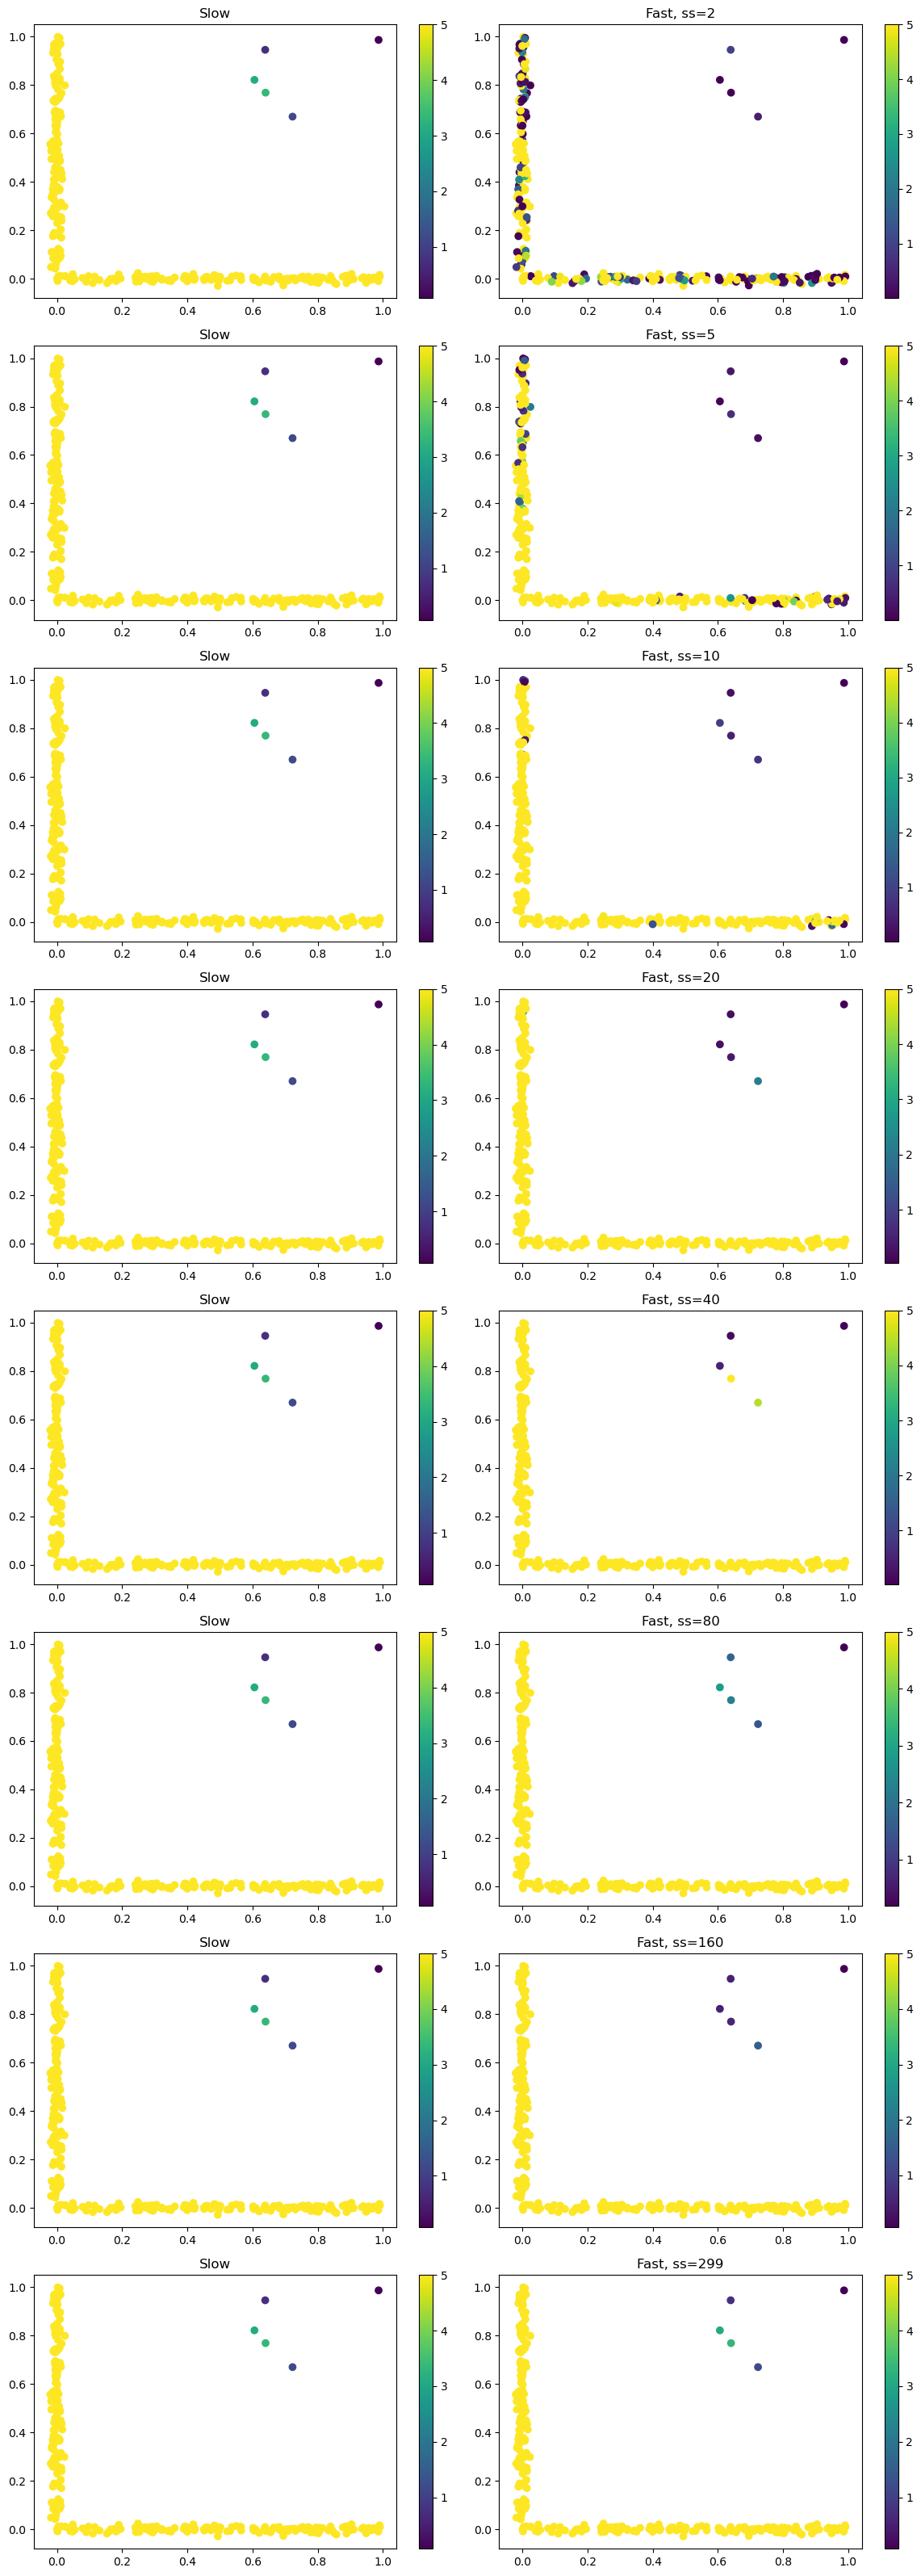

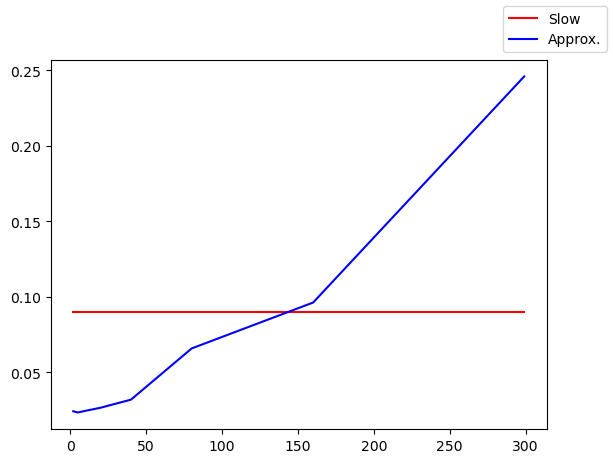

In [10]:
X, y = load_synthetic_data()
sel = np.argsort(y)[::-1] # Choose point such that we have some outliers to play with.
X = X[sel[:300]]
y = y[sel[:300]]

# Choose the first 300 rows and only the first two dimensions. 
# We can't choose too many rows as we are looking at an O(n^3) algorithm here.
X = X[:,8:10]
n, d = X.shape

sample_sizes = [2, 5, 10, 20, 40, 80, 160, n-1]
fig, ax = plt.subplots(len(sample_sizes), 2, figsize=(12, len(sample_sizes)*4))

times = []
runs  = 10

t0 = time.time()
for _ in range(runs): A1 = ABOD(X)
t_slow = time.time() - t0
t_slow /= runs

for i, ss in enumerate(sample_sizes):
    t0 = time.time()
    for _ in range(runs): A2 = ABOD(X, ss)
    t_fast = time.time() - t0
    t_fast /= runs
    
    times.append((t_slow, t_fast))
    cf = ax[i,0].scatter(*(X.T), c=A1)
    ax[i, 0].set_title("Slow")
    fig.colorbar(cf, ax=ax[i, 0])
    
    cf = ax[i,1].scatter(*(X.T), c=A2)
    ax[i,1].set_title("Fast, ss=%i" % ss)
    fig.colorbar(cf, ax=ax[i, 1])    

plt.tight_layout()

fig, ax = plt.subplots(1,1)
times = np.array(times).T
print(times.shape)
print(len(sample_sizes))
ax.plot(sample_sizes, times[0], 'r-', label="Slow")
ax.plot(sample_sizes, times[1], 'b',  label="Approx.")
fig.legend()